# Lab Assignment Four: Multi-Layer Perceptron 

Team Members: Nicholas Benso, Benjamin Kuo

Dataset Selection: US Census data

Box Link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0Links

Kaggle Link: https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks

The classification task you will be performing is to predict, for each county, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

## Load, Split, and Balance (1.5 points total)
[.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. (3) Encode any string data as integers for now. (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 
The next two requirements will need to be completed together as they might depend on one another:

[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

[.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.
Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 


In [42]:
import os
current_directory = os.getcwd()
print(current_directory) 

C:\Users\benny\Jupyter\Lab4


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import sys

df = pd.read_csv(current_directory + "\\acs2017_census_tract_data.csv") # read in the csv file

df.info()
df.describe()

df.dropna(subset='ChildPoverty',inplace=True)
for col in df:
    if df[col].count() < df.shape[0]:
        del df[col]

del df['TractId']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

In [74]:
county = pd.unique(df['County'])
county_num = np.linspace(0,county.shape[0]-1,num=county.shape[0],dtype=np.int32)
df['County'].replace(county,county_num,inplace=True)

state = pd.unique(df['State'])
state_num = np.linspace(0,state.shape[0]-1,num=state.shape[0],dtype=np.int32)
df['State'].replace(state,state_num,inplace=True)

df['ChildPoverty'].quantile([.25, .5, .75])

0.25     6.2
0.50    16.3
0.75    31.6
Name: ChildPoverty, dtype: float64

Since TractID is simply an ID used to track each data entry, we can remove it as it doesn’t contain any useful prediction information. We kept the county variable, as the end goal is to be able to predict the poverty rate of a certain county, so including the county as a feature may be very helpful in helping predict the general range of child poverty rates. 

In [75]:
for index, row in df.iterrows():
    if row["ChildPoverty"] < 6.2:
        df.at[index, 'ChildPoverty'] = 0
    elif row["ChildPoverty"] >= 6.2 and row["ChildPoverty"] < 16.3:
        df.at[index, 'ChildPoverty'] = 1
    elif row["ChildPoverty"] >= 16.3 and row["ChildPoverty"] < 31.6:
        df.at[index, 'ChildPoverty'] = 2
    elif row["ChildPoverty"] >= 31.6:
        df.at[index, 'ChildPoverty'] = 3
    int(row["ChildPoverty"])
    
tmpdf = pd.get_dummies(df['ChildPoverty'],prefix='quartile')
tmpdf.head()

,quartile_0.0,quartile_1.0,quartile_2.0,quartile_3.0
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0


In [76]:
from sklearn.model_selection import ShuffleSplit, train_test_split
# we want to predict the X and y data as follows:
if 'ChildPoverty' in df:
    y = df['ChildPoverty'].to_numpy() # get the labels we want   
    del df['ChildPoverty']
    
    
    #norm_features = ['State', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Poverty', 'Employed']
    #df[norm_features] = (df[norm_features]-df[norm_features].mean()) / df[norm_features].std()
    X = df.to_numpy() # use everything else to predict!
    #df = pd.concat((df,tmpdf),axis=1)

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, shuffle = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 74000
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72891 non-null  int32  
 1   County            72891 non-null  int32  
 2   TotalPop          72891 non-null  int64  
 3   Men               72891 non-null  int64  
 4   Women             72891 non-null  int64  
 5   Hispanic          72891 non-null  float64
 6   White             72891 non-null  float64
 7   Black             72891 non-null  float64
 8   Native            72891 non-null  float64
 9   Asian             72891 non-null  float64
 10  Pacific           72891 non-null  float64
 11  VotingAgeCitizen  72891 non-null  int64  
 12  Poverty           72891 non-null  float64
 13  Employed          72891 non-null  int64  
dtypes: float64(7), int32(2), int64(5)
memory usage: 9.8 MB


We chose to quantize the target feature into four classes, splitting it evenly in 25% intervals and dividing each up into a distinct target class. The balancing should be done for the entire dataset, as this ensures that the prediction classes are evenly split among all the data. While actual data the model may encounter might be differently distributed from these quartile ranges chosen here, by using the entire dataset, we ensure that these ranges are informed by the most amount of data we currently have, rather than relying on a smaller dataset of just the training data.

## Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.


In [77]:
from sklearn.metrics import accuracy_score

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

    
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    


### Not Normalized or One-Hot Encoded

Epoch: 1/200

Wall time: 6.59 s


Epoch: 1/200

Wall time: 6.13 s


Epoch: 20/20

Wall time: 7.2 s
Cross Entropy Loss :
Resubstitution acc: 0.2498456578405817
Validation acc: 0.2526922285479114
MSE Loss :
Resubstitution acc: 0.24816504321580463
Validation acc: 0.24919404623088004
Glorot Initial :
Resubstitution acc: 0.25099464947180683
Validation acc: 0.24960559709170724


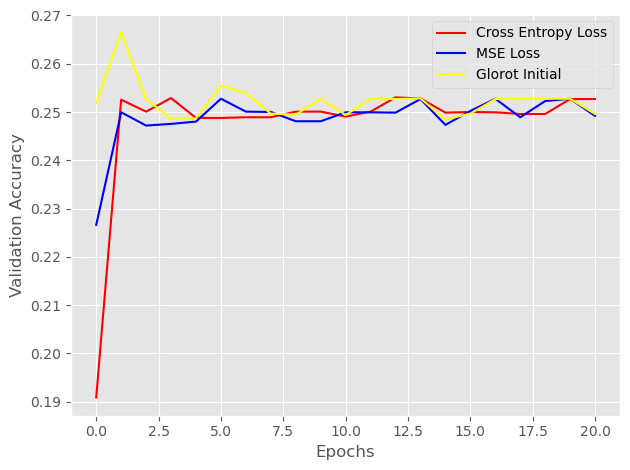

In [79]:
from sklearn import metrics as mt
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}


nn_quad = TLPMiniBatch(**vals)
nn_cross = TLPMiniBatchCrossEntropy(**vals)
nn_better = TLPBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

plt.show()

### Normalized

Epoch: 1/200

Wall time: 3.81 s


Epoch: 1/200

Wall time: 3.62 s


Epoch: 20/20

Wall time: 3.33 s
Cross Entropy Loss :
Resubstitution acc: 0.720760735354644
Validation acc: 0.7179504767130804
MSE Loss :
Resubstitution acc: 0.7152215667444094
Validation acc: 0.7134234172439811
Glorot Initial :
Resubstitution acc: 0.7142097681437783
Validation acc: 0.714520886206187


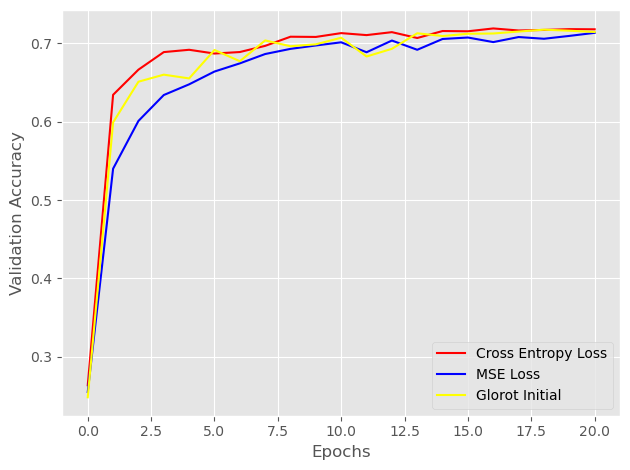

In [80]:
norm_features = ['State', 'County','TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Poverty', 'Employed']
df[norm_features] = (df[norm_features]-df[norm_features].mean()) / df[norm_features].std()
X = df.to_numpy() # use everything else to predict!
#df = pd.concat((df,tmpdf),axis=1)

## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, shuffle = True)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

### Normalzied and One-Hot Encoded

Epoch: 20/20

Wall time: 1min 12s


Epoch: 20/20

Wall time: 1min 1s


Epoch: 20/20

Wall time: 50.2 s
Cross Entropy Loss :
Resubstitution acc: 0.7148442859102757
Validation acc: 0.7072501543315728
MSE Loss :
Resubstitution acc: 0.7023082727397448
Validation acc: 0.7003909733177859
Glorot Initial :
Resubstitution acc: 0.7278604746878858
Validation acc: 0.7226833116125935


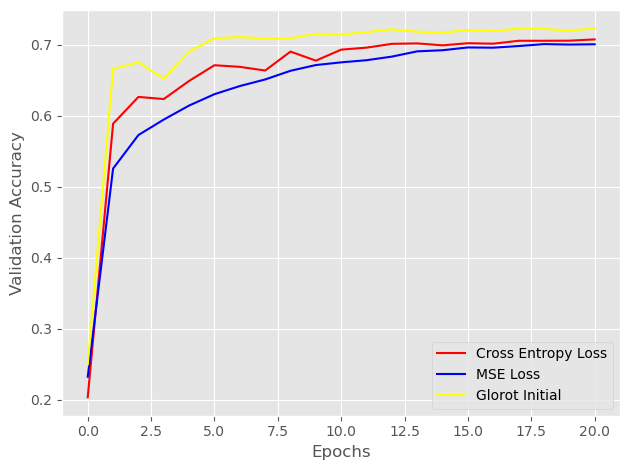

In [81]:
categ_features = ['State','County'];
one_hot_df = pd.concat([pd.get_dummies(df[col],prefix=col) for col in categ_features], axis=1)
df = pd.concat((df,one_hot_df),axis=1)
del df['State']
del df['County']
X = df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, shuffle = True)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

## Modeling (5 points total)
[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

[1 points] Repeat the previous step, adding support for a fourth layer.

[1 points] Repeat the previous step, adding support for a fifth layer. 

[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

## Three Layer Perceptron

In [91]:
class ThreeLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    '''
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden + 1)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden + 1)
        
        return W1, W2, W3
        
    '''
    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        
        W3_num_elems = (self.n_hidden)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden)
        
        return W1, W2, W3

   
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * (np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2)))

    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        """Get the objective function value"""
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
                                
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step
        """
        #A1 = self._add_bias_unit(X.T, how='row')
        A1 = X.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        #A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        #A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

                       
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)  # last layer sensitivity
        V2 = A3*(1-A3)*(W3.T @ V3) # back prop the sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad3 = V3 @ A3.T # no bias on final layer
        grad2 = V2 @ A2.T # dont back prop sensitivity of bias
        grad1 = V1 @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        
        g1, g2, g3 = grad1, grad2, grad3
        return grad1, grad2, grad3

                                
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4  = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

class ThreeLayerPerceptronMiniBatch(ThreeLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3)
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)

                # momentum calculations
                rho_W1, rho_W2, rho_W3 = eta * grad1, eta * grad2, eta * grad3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    
class ThreeLayerPerceptronMiniBatchCrossEntropy(ThreeLayerPerceptronMiniBatch):
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = (A4-Y_enc) # <- this is only line that changed
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad3 = V3 @ A3.T
        grad2 = V2 @ A2.T
        grad1 = V1 @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3

    
class ThreeLayerPerceptronBetterInitial(ThreeLayerPerceptronMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W2[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W3[:,:1] = 0
        
        return W1, W2, W3

In [92]:
#plotting gradients versus epochs
def print_grad(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    
    #gradient plot
    plt.plot(range(len(nn.g1)), nn.g1,range(len(nn.g2)), nn.g2,range(len(nn.g3)), nn.g3, color=color,label=title)
    plt.ylabel('Average Gradients')

    return W1, W2, W3

Epoch: 5/5

Wall time: 12.9 s


Epoch: 5/5

Wall time: 9.97 s


Epoch: 5/5

Wall time: 10.6 s
Cross Entropy Loss :
Resubstitution acc: 0.695620112498285
Validation acc: 0.6907881198984841
MSE Loss :
Resubstitution acc: 0.6621621621621622
Validation acc: 0.6590301118046505
Glorot Initial :
Resubstitution acc: 0.7199375771710798
Validation acc: 0.7184992111941834


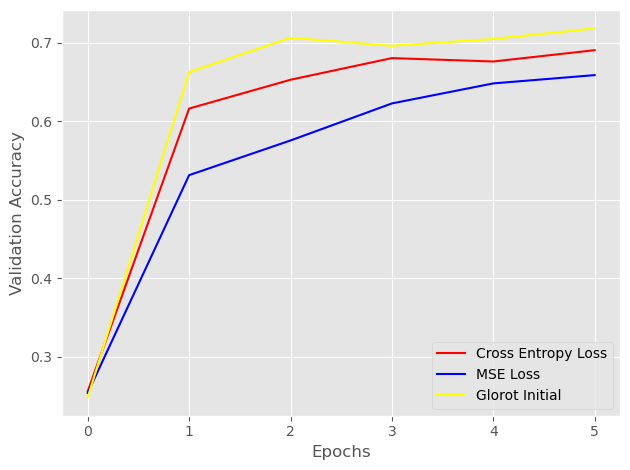

In [93]:
#CHANGE BACK TO 20 EPOCHS!
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':5, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = ThreeLayerPerceptronMiniBatch(**vals)
nn_cross = ThreeLayerPerceptronMiniBatchCrossEntropy(**vals)
nn_better = ThreeLayerPerceptronBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

## Four Layer Perceptron

In [94]:
class FourLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        
        W3_num_elems = (self.n_hidden)*self.n_hidden
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden, self.n_hidden)
        
        W4_num_elems = (self.n_hidden)*self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden)
        
        return W1, W2, W3, W4
    
    #This is based off the TwoLayer method
    #But I think it might be incorrect, online it doesn't seem like L2 regularization has sqrt()
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * (np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)))

    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        """Get the objective function value"""
        cost = np.mean((Y_enc-A5)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3,W4)
        return cost + L2_term
                                
    def _feedforward(self, X, W1, W2, W3, W4):
        """Compute feedforward step
        """
        #A1 = self._add_bias_unit(X.T, how='row')
        A1 = X.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        #A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        #A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        #A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

                       
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = -2*(Y_enc-A5)*A5*(1-A5)  # last layer sensitivity
        V3 = A4*(1-A4)*(W4.T @ V4) # back prop the sensitivity
        V2 = A3*(1-A3)*(W3.T @ V3) # back prop the sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity
        
        grad4 = V4 @ A4.T # no bias on final layer
        grad3 = V3 @ A3.T # dont back prop sensitivity of bias
        grad2 = V2 @ A2.T # dont back prop sensitivity of bias
        grad1 = V1 @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        
        g1, g2, g3, g4 = grad1, grad2, grad3, grad4
        return grad1, grad2, grad3, grad4

                                
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5  = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

class FourLayerPerceptronMiniBatch(FourLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4)
                
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3, self.W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3, W4=self.W4)

                # momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4 = eta * grad1, eta * grad2, eta * grad3, eta * grad4
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    
class FourLayerPerceptronMiniBatchCrossEntropy(FourLayerPerceptronMiniBatch):
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = (A5-Y_enc) # <- this is only line that changed
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad4 = V4 @ A4.T
        grad3 = V3 @ A3.T
        grad2 = V2 @ A2.T
        grad1 = V1 @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4

    
class FourLayerPerceptronBetterInitial(FourLayerPerceptronMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W3[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4

Epoch: 5/5

Wall time: 11.4 s


Epoch: 5/5

Wall time: 8.12 s


Epoch: 5/5

Wall time: 8.73 s
Cross Entropy Loss :
Resubstitution acc: 0.694539717382357
Validation acc: 0.689279100075451
MSE Loss :
Resubstitution acc: 0.6638770750445877
Validation acc: 0.6607449070580973
Glorot Initial :
Resubstitution acc: 0.6971978323501166
Validation acc: 0.6968927910007545


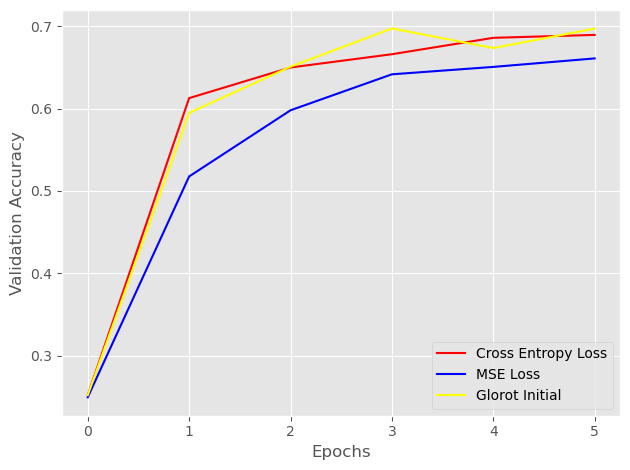

In [97]:
#CHANGE BACK TO 20 EPOCHS!
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':5, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = FourLayerPerceptronMiniBatch(**vals)
nn_cross = FourLayerPerceptronMiniBatchCrossEntropy(**vals)
nn_better = FourLayerPerceptronBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

## Five Layer Perceptron

In [104]:
class FiveLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        
        W2_num_elems = (self.n_hidden)*self.n_hidden
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden)
        
        W3_num_elems = (self.n_hidden)*self.n_hidden
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden, self.n_hidden)
        
        W4_num_elems = (self.n_hidden)*self.n_hidden
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden, self.n_hidden)
        
        W5_num_elems = (self.n_hidden)*self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden)
        
        return W1, W2, W3, W4, W5
    
    #This is based off the TwoLayer method
    #But I think it might be incorrect, online it doesn't seem like L2 regularization has sqrt()
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * (np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2)))

    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        """Get the objective function value"""
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
                                
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step
        """
        #A1 = self._add_bias_unit(X.T, how='row')
        A1 = X.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        #A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        #A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        #A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        #A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

                       
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)  # last layer sensitivity
        V4 = A5*(1-A5)*(W5.T @ V5) # back prop the sensitivity
        V3 = A4*(1-A4)*(W4.T @ V4) # back prop the sensitivity
        V2 = A3*(1-A3)*(W3.T @ V3) # back prop the sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity
        
        grad5 = V5 @ A5.T # no bias on final layer
        grad4 = V4 @ A4.T # dont back prop sensitivity of bias
        grad3 = V3 @ A3.T # dont back prop sensitivity of bias
        grad2 = V2 @ A2.T # dont back prop sensitivity of bias
        grad1 = V1 @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C
        
        g1, g2, g3, g4, g5 = grad1, grad2, grad3, grad4, grad5
        return grad1, grad2, grad3, grad4, grad5

                                
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6  = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

class FiveLayerPerceptronMiniBatch(FiveLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3, self.W4, self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3, W4=self.W4, W5=self.W5)

                # momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * grad1, eta * grad2, eta * grad3, eta * grad4, eta * grad5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    
class FiveLayerPerceptronMiniBatchCrossEntropy(FiveLayerPerceptronMiniBatch):
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = (A6-Y_enc) # <- this is only line that changed
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad5 = V5 @ A5.T
        grad4 = V4 @ A4.T
        grad3 = V3 @ A3.T
        grad2 = V2 @ A2.T
        grad1 = V1 @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5

    
class FiveLayerPerceptronBetterInitial(FiveLayerPerceptronMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W4[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5

Epoch: 5/5

Wall time: 12 s


Epoch: 5/5

Wall time: 9.63 s


Epoch: 5/5

Wall time: 8.8 s
Cross Entropy Loss :
Resubstitution acc: 0.6944882699958842
Validation acc: 0.6920227724809658
MSE Loss :
Resubstitution acc: 0.660807380985046
Validation acc: 0.6612250497290624
Glorot Initial :
Resubstitution acc: 0.641497461928934
Validation acc: 0.6421565265107346


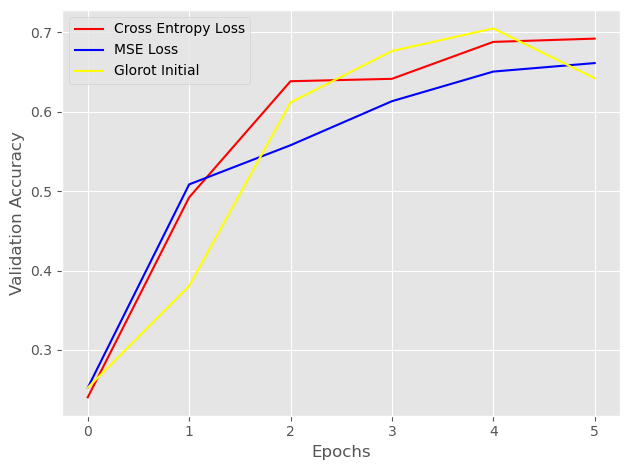

In [105]:
#CHANGE BACK TO 20 EPOCHS!
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':5, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = FiveLayerPerceptronMiniBatch(**vals)
nn_cross = FiveLayerPerceptronMiniBatchCrossEntropy(**vals)
nn_better = FiveLayerPerceptronBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")

## Adaptive Strategy: AdaGrad

Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

In [112]:
class AdaptFiveLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

class AdaptFiveLayerPerceptronMiniBatch(FiveLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, gamma=0.95,e=10**(-8),**kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.gamma = gamma
        self.e = e
        # but keep other keywords
        super().__init__(**kwds)      
        
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        G_W1_prev = np.zeros(self.W1.shape)
        G_W2_prev = np.zeros(self.W2.shape)
        G_W3_prev = np.zeros(self.W3.shape)
        G_W4_prev = np.zeros(self.W4.shape)
        G_W5_prev = np.zeros(self.W5.shape)
        

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
    
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3, self.W4, self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3, W4=self.W4, W5=self.W5)
                '''
                # momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * grad1, eta * grad2, eta * grad3, eta * grad4, eta * grad5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5
                '''
                
                # adaptive calculations                
                G_W1 = self.gamma*G_W1_prev + grad1**2
                G_W2 = self.gamma*G_W2_prev + grad2**2
                G_W3 = self.gamma*G_W3_prev + grad3**2
                G_W4 = self.gamma*G_W4_prev + grad4**2
                G_W5 = self.gamma*G_W5_prev + grad5**2
            
                rho_W1 = (1/np.sqrt(G_W1 + self.e))*grad1
                rho_W2 = (1/np.sqrt(G_W2 + self.e))*grad2
                rho_W3 = (1/np.sqrt(G_W3 + self.e))*grad3
                rho_W4 = (1/np.sqrt(G_W4 + self.e))*grad4
                rho_W5 = (1/np.sqrt(G_W5 + self.e))*grad5
            
                self.W1 -= (self.eta * rho_W1)
                self.W2 -= (self.eta * rho_W2)
                self.W3 -= (self.eta * rho_W3)
                self.W4 -= (self.eta * rho_W4)
                self.W5 -= (self.eta * rho_W5)
                G_W1_prev, G_W2_prev, G_W3_prev, G_W4_prev, G_W5_prev = G_W1, G_W2, G_W3, G_W4, G_W5
        
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
                
class AdaptFiveLayerPerceptronMiniBatchCrossEntropy(AdaptFiveLayerPerceptronMiniBatch):
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = (A6-Y_enc) # <- this is only line that changed
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad5 = V5 @ A5.T
        grad4 = V4 @ A4.T
        grad3 = V3 @ A3.T
        grad2 = V2 @ A2.T
        grad1 = V1 @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5

    
class AdaptFiveLayerPerceptronBetterInitial(AdaptFiveLayerPerceptronMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        W4[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5

Epoch: 5/5

Wall time: 11.2 s


Epoch: 5/5

Wall time: 9.42 s


Epoch: 5/5

Wall time: 8.24 s
Cross Entropy Loss :
Resubstitution acc: 0.31060502126491973
Validation acc: 0.31689416283695726
MSE Loss :
Resubstitution acc: 0.4594423103306352
Validation acc: 0.45737018999931406
Glorot Initial :
Resubstitution acc: 0.24936548223350255
Validation acc: 0.2524178613073599


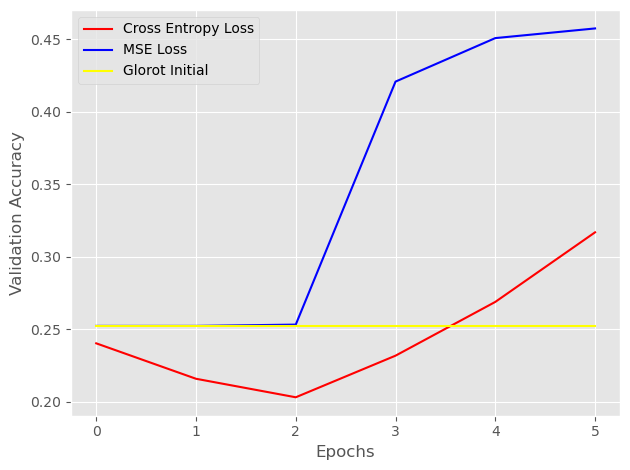

In [113]:
#CHANGE BACK TO 20 EPOCHS!
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':5, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = AdaptFiveLayerPerceptronMiniBatch(**vals)
nn_cross = AdaptFiveLayerPerceptronMiniBatchCrossEntropy(**vals)
nn_better = AdaptFiveLayerPerceptronBetterInitial(**vals)
%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="yellow")